## Forecast unseen data using fitted models

The order is important!

1. Renewables: Predictions based on weather data
- Solar
- Wind onshore
- Wind offshore

2. Consumption, Other renewables: Predictions based on datetime features only

3. Fossils: Predictions based on renewables and consumption
- Brown coal
- Hard coal
- Gas
- Other Fossils
- Hydro Pumped Storage

4. Price: Prediction based on all generation types and consumption

5. Compute CO2 emissions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt, timedelta
import os

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from MaStR import get_MaStR
from entso_e import get_generation_data, aggregate_generation_data, get_price, plot_generation
from DataAggregation import clean_consumption, compute_emissions, cluster_facilities, plot_facilities, aggregate_data
from Weather import get_weather_data
from REForecasting import *

# Ensure modules are reloaded after changes have been made
%load_ext autoreload
%aimport REForecasting

In [2]:
# Time period to be predicted
start_date = "2023-08-01"
end_date = "2023-08-08"
timezone = "Europe/Brussels"

start = pd.Timestamp(f"{start_date}T00:00:00", tz=timezone).floor(freq="h")
end = pd.Timestamp(f"{end_date}T00:00:00", tz=timezone).floor(freq="h")

# If the time period lies in the past, predictions can be compared with real data
if end <= pd.Timestamp.now(tz=timezone):
    PAST = 1
    
# Directories
fpath = "data"
save_path = f"{fpath}/forecasts/{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}"
model_path = "models/20180801-20230801"
if not os.path.isdir(save_path):
    os.makedirs(save_path)


## 0. Get real data from entso-e for comparison
Only for forecast periods that lie in the past.

In [3]:
LOAD_FROM_FILE = 0
entsoe_path = f"{save_path}/entsoe"
if not os.path.isdir(entsoe_path):
    os.makedirs(entsoe_path)

##### Generation data

In [4]:
if PAST:
    if LOAD_FROM_FILE:
        generation_df = pd.read_parquet(f"{entsoe_path}/generation_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")
    else:
        area_code = "10YDE-VE-------2" # 50Hertz control area
        generation_df = get_generation_data(area_code, start, end)
        generation_df.to_parquet(f"{entsoe_path}/generation_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")

Retrieving electricity generation data from entso-e transparency platform...
Done!


##### Price

In [5]:
if PAST:
    if LOAD_FROM_FILE:
        price_df = pd.read_parquet(f"{entsoe_path}/price_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")
    else:    
        price_df = get_price("DE_LU", start, end, generation_df)
        price_df.to_parquet(f"{entsoe_path}/price_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")

Retrieving electricity price data from entso-e transparency platform...
Done!


##### Consumption
From Smard.de (Bundesnetzagentur) --> Download relevant time period as csv file

In [6]:
if PAST:
    if LOAD_FROM_FILE:
        consumption_df = pd.read_parquet(f"{save_path}/consumption/consumption_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")
    else:
        consumption_csv = f"{save_path}/smard/Realisierter_Stromverbrauch_{start.strftime('%Y%m%d0000')}_{(end-timedelta(minutes=1)).strftime('%Y%m%d2359')}_Stunde.csv"
        consumption_df = pd.read_csv(consumption_csv, delimiter=";")
        consumption_df = clean_consumption(consumption_df, generation_df)
        consumption_path = f"{save_path}/consumption/"
        if not os.path.isdir(consumption_path):
            os.makedirs(consumption_path)
        consumption_df.to_parquet(f"{consumption_path}/consumption_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")

##### CO2 emissions

In [7]:
if PAST:
    emission_df = compute_emissions(generation_df)

# Predictions

#### Make Data Frame to hold predictions

In [8]:
generation_forecast = pd.DataFrame()
consumption_forecast = pd.DataFrame()
price_forecast = pd.DataFrame()

## 1. Renewables

### Solar

##### Get facilities and clusters

In [9]:
load_version = "20230704"
solar_df = pd.read_parquet(f"{fpath}/MaStR_data/solar_MaStR_{load_version}.parquet")
solar_cluster_centers = pd.read_parquet(f"{fpath}/MaStR_data/solar_clusters_100_{load_version}.parquet")

##### Get weather data

In [10]:
LOAD_FROM_FILE = 0
if LOAD_FROM_FILE:
    solar_weather_df = pd.read_parquet(f"{save_path}/weather/solar/100_clusters/weather_data_weighted_avg.parquet")
else:
    solar_weather_df = get_weather_data(cluster_df=solar_cluster_centers, 
                                        save_path=save_path, 
                                        energy_type="solar", 
                                        start=start.strftime("%Y-%m-%d"),
                                        end=(end-timedelta(days=1)).strftime("%Y-%m-%d"),
                                        timezone=timezone)

Retrieving weather data...
100/100
Done!


##### Aggregate data

In [11]:
# Get aggregate df
solar_test_df = aggregate_data(solar_df, solar_weather_df)

# Save df
solar_test_df.to_parquet(f"{save_path}/solar_data_final_100_clusters_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

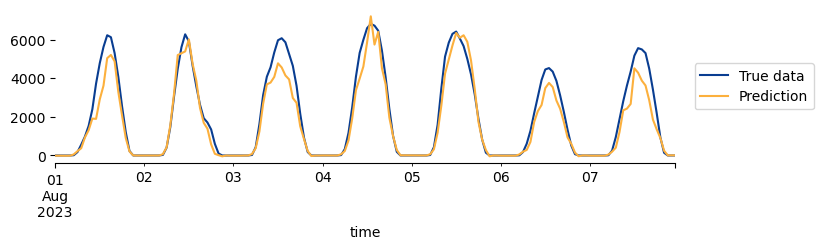

In [12]:
gen_type = "Solar"

# Load model
solar_model = xgb.XGBRegressor()
solar_model.load_model(f"{model_path}/solar_xgboost_cv_5years_100clusters.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
solar_test_df = make_forecast(solar_test_df, solar_model, true_df=true_df)
generation_forecast[gen_type] = solar_test_df["prediction"]

### Wind onshore

##### Get facilities and clusters

In [13]:
load_version = "20230704"
wind_onshore_df = pd.read_parquet(f"{fpath}/MaStR_data/wind_onshore_MaStR_{load_version}.parquet")
wind_onshore_cluster_centers = pd.read_parquet(f"{fpath}/MaStR_data/wind_onshore_clusters_100_{load_version}.parquet")

##### Get weather data

In [14]:
LOAD_FROM_FILE = 0
if LOAD_FROM_FILE:
    wind_onshore_weather_df = pd.read_parquet(f"{save_path}/weather/wind_onshore/100_clusters/weather_data_weighted_avg.parquet")
else:
    wind_onshore_weather_df = get_weather_data(cluster_df=wind_onshore_cluster_centers, 
                                        save_path=save_path, 
                                        energy_type="wind_onshore", 
                                        start=start.strftime("%Y-%m-%d"),
                                        end=(end-timedelta(days=1)).strftime("%Y-%m-%d"),
                                        timezone=timezone)

Retrieving weather data...
100/100
Done!


##### Aggregate data

In [15]:
# Get aggregate df
wind_onshore_test_df = aggregate_data(wind_onshore_df, wind_onshore_weather_df)

# Save df
wind_onshore_test_df.to_parquet(f"{save_path}/wind_onshore_data_final_100_clusters_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

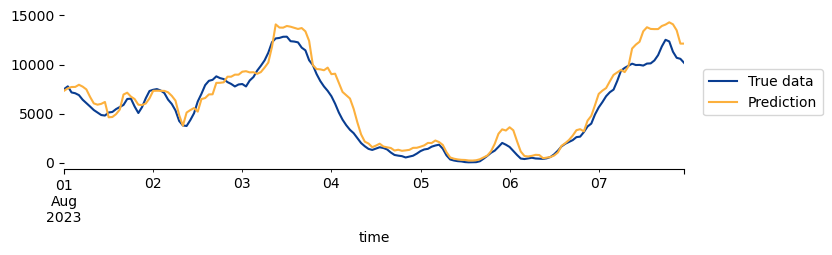

In [16]:
gen_type = "Wind Onshore"
    
# Load model
onshore_model = xgb.XGBRegressor()
onshore_model.load_model(f"{model_path}/wind_onshore_xgboost_cv_5years_100clusters.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
wind_onshore_test_df = make_forecast(wind_onshore_test_df, onshore_model, true_df=true_df)
generation_forecast[gen_type] = wind_onshore_test_df["prediction"]

### Wind offshore

##### Get facilities and clusters

In [17]:
load_version = "20230704"
wind_offshore_df = pd.read_parquet(f"{fpath}/MaStR_data/wind_offshore_MaStR_{load_version}.parquet")
wind_offshore_cluster_centers = pd.read_parquet(f"{fpath}/MaStR_data/wind_offshore_clusters_6_{load_version}.parquet")

##### Get weather data

In [19]:
LOAD_FROM_FILE = 0
if LOAD_FROM_FILE:
    wind_offshore_weather_df = pd.read_parquet(f"{save_path}/weather/wind_offshore/6_clusters/weather_data_weighted_avg.parquet")
else:
    wind_offshore_weather_df = get_weather_data(cluster_df=wind_offshore_cluster_centers, 
                                        save_path=save_path, 
                                        energy_type="wind_offshore", 
                                        start=start.strftime("%Y-%m-%d"),
                                        end=(end-timedelta(days=1)).strftime("%Y-%m-%d"),
                                        timezone=timezone)

Retrieving weather data...
6/6
Done!


##### Aggregate data

In [20]:
# Get aggregate df
wind_offshore_test_df = aggregate_data(wind_offshore_df, wind_offshore_weather_df)

# Save df
wind_offshore_test_df.to_parquet(f"{save_path}/wind_offshore_data_final_6_clusters_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

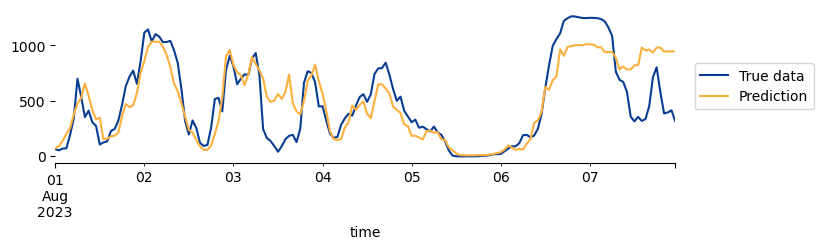

In [21]:
gen_type = "Wind Offshore"

# Load model
offshore_model = xgb.XGBRegressor()
offshore_model.load_model(f"{model_path}/wind_offshore_xgboost_cv_5years_6clusters.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
wind_offshore_test_df = make_forecast(wind_offshore_test_df, offshore_model, true_df=true_df)
generation_forecast[gen_type] = wind_offshore_test_df["prediction"]

## 2. Predictions based on datetime features only

### Other renewables

##### Aggregate data

In [22]:
other_renewables_test_df = pd.DataFrame(index=generation_df.index)

# Save df
other_renewables_test_df.to_parquet(f"{save_path}/other_renewables_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

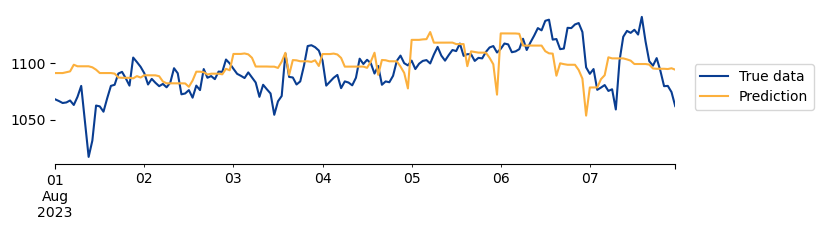

In [23]:
gen_type = "Other renewables"

# Load model
other_renewables_model = xgb.XGBRegressor()
other_renewables_model.load_model(f"{model_path}/other_renewables_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
other_renewables_test_df = make_forecast(other_renewables_test_df, other_renewables_model, true_df=true_df)
generation_forecast[gen_type] = other_renewables_test_df["prediction"]

### Consumption

##### Aggregate data

In [24]:
consumption_test_df = pd.DataFrame(index=generation_df.index)

# Save df
consumption_test_df.to_parquet(f"{save_path}/consumption_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

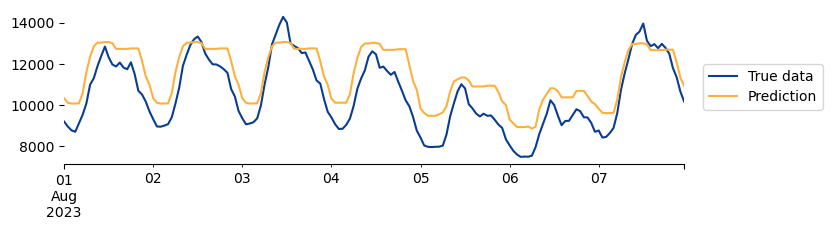

In [25]:
plot_col = "Gesamtnetzlast"

# Load model
consumption_model = xgb.XGBRegressor()
consumption_model.load_model(f"{model_path}/consumption_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df[plot_col] = consumption_df[plot_col]   
else:
    true_df = None
    
consumption_test_df = make_forecast(consumption_test_df, consumption_model, true_df=true_df, target=plot_col)
consumption_forecast[plot_col] = consumption_test_df["prediction"]

## 3. Fossils: Predictions based on renewables and consumption
- Brown coal
- Hard coal
- Gas
- Other Fossils
- Hydro Pumped Storage

### Brown coal

##### Aggregate data

In [26]:
brown_coal_test_df = generation_forecast[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
brown_coal_test_df["total_consumption"] = consumption_forecast["Gesamtnetzlast"]

# Save df
brown_coal_test_df.to_parquet(f"{save_path}/brown_coal_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

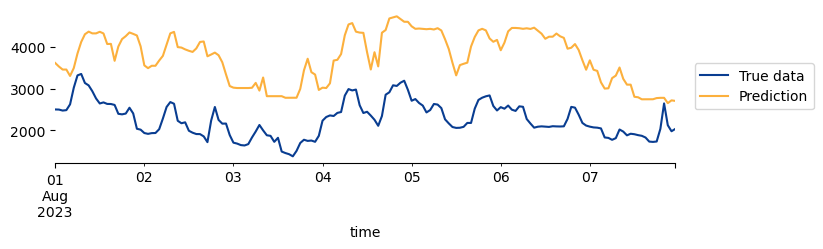

In [27]:
gen_type = "Fossil Brown coal/Lignite"

# Load model
brown_coal_model = xgb.XGBRegressor()
brown_coal_model.load_model(f"{model_path}/brown_coal_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
brown_coal_test_df = make_forecast(brown_coal_test_df, brown_coal_model, true_df=true_df)
generation_forecast[gen_type] = brown_coal_test_df["prediction"]

### Hard coal

##### Aggregate data

In [28]:
hard_coal_test_df = generation_forecast[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
hard_coal_test_df["total_consumption"] = consumption_forecast["Gesamtnetzlast"]

# Save df
hard_coal_test_df.to_parquet(f"{save_path}/hard_coal_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

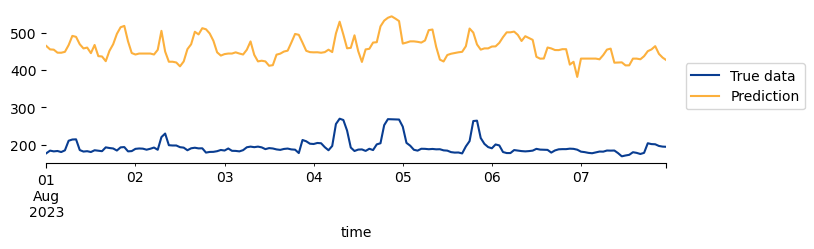

In [29]:
gen_type = "Fossil Hard coal"

# Load model
hard_coal_model = xgb.XGBRegressor()
hard_coal_model.load_model(f"{model_path}/hard_coal_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
hard_coal_test_df = make_forecast(hard_coal_test_df, hard_coal_model, true_df=true_df)
generation_forecast[gen_type] = hard_coal_test_df["prediction"]

### Gas

##### Aggregate data

In [30]:
gas_test_df = generation_forecast[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
gas_test_df["total_consumption"] = consumption_forecast["Gesamtnetzlast"]

# Save df
gas_test_df.to_parquet(f"{save_path}/gas_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

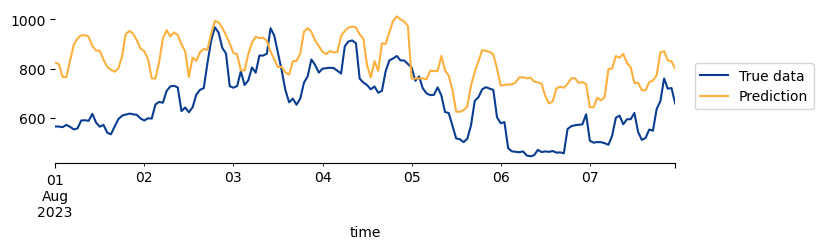

In [31]:
gen_type = "Fossil Gas"

# Load model
gas_model = xgb.XGBRegressor()
gas_model.load_model(f"{model_path}/gas_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
gas_test_df = make_forecast(gas_test_df, gas_model, true_df=true_df)
generation_forecast[gen_type] = gas_test_df["prediction"]

### Other Fossils

##### Aggregate data

In [32]:
other_fossils_test_df = generation_forecast[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
other_fossils_test_df["total_consumption"] = consumption_forecast["Gesamtnetzlast"]

# Save df
other_fossils_test_df.to_parquet(f"{save_path}/other_fossils_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

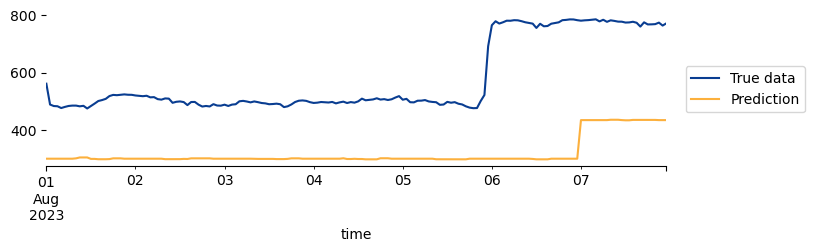

In [33]:
gen_type = "Other fossils"

# Load model
other_fossils_model = xgb.XGBRegressor()
other_fossils_model.load_model(f"{model_path}/other_fossils_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
other_fossils_test_df = make_forecast(other_fossils_test_df, other_fossils_model, true_df=true_df)
generation_forecast[gen_type] = other_fossils_test_df["prediction"]

### Hydro Pumped Storage

##### Aggregate data

In [34]:
hydro_pumped_storage_test_df = generation_forecast[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
hydro_pumped_storage_test_df["total_consumption"] = consumption_forecast["Gesamtnetzlast"]

# Save df
hydro_pumped_storage_test_df.to_parquet(f"{save_path}/hydro_pumped_storage_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

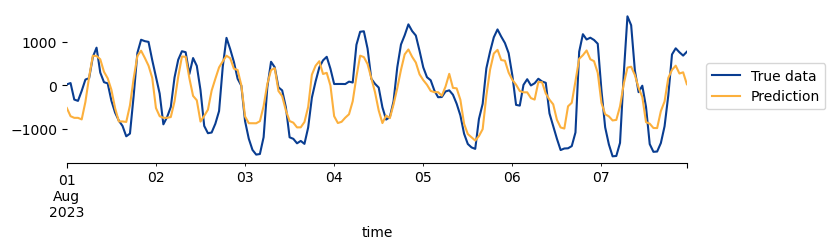

In [35]:
gen_type = "Hydro Pumped Storage"

# Load model
hydro_pumped_storage_model = xgb.XGBRegressor()
hydro_pumped_storage_model.load_model(f"{model_path}/hydro_pumped_storage_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df["generated_electricity"] = generation_df[gen_type]   
else:
    true_df = None
    
hydro_pumped_storage_test_df = make_forecast(hydro_pumped_storage_test_df, hydro_pumped_storage_model, true_df=true_df)
generation_forecast[gen_type] = hydro_pumped_storage_test_df["prediction"]

## 4. Prediction based on all generation types and consumption

### Price

##### Aggregate data

In [36]:
price_test_df = generation_forecast.copy()
price_test_df["total_consumption"] = consumption_forecast["Gesamtnetzlast"]

# Save df
price_test_df.to_parquet(f"{save_path}/price_data_final_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

##### Make prediction

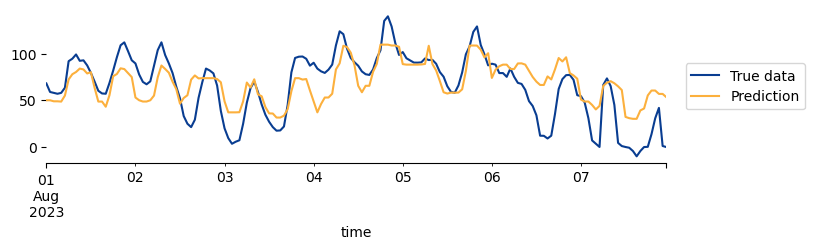

In [37]:
plot_col = "prices"

# Load model
price_model = xgb.XGBRegressor()
price_model.load_model(f"{model_path}/price_xgboost_cv_5years.json")

if PAST:
    true_df = pd.DataFrame()
    true_df[plot_col] = price_df[plot_col]   
else:
    true_df = None
    
price_test_df = make_forecast(price_test_df, price_model, true_df=true_df, target=plot_col)
price_forecast[plot_col] = price_test_df["prediction"]

## 5. Compute CO2 emissions

In [38]:
emissions_forecast = compute_emissions(generation_forecast)

# Save forecasts

In [39]:
generation_forecast.to_parquet(f"{save_path}/generation_forecast_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")
consumption_forecast.to_parquet(f"{save_path}/consumption_forecast_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")
price_forecast.to_parquet(f"{save_path}/price_forecast_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")
emissions_forecast.to_parquet(f"{save_path}/emissions_forecast_{start_date.replace('-','')}-{end_date.replace('-','')}.parquet")

# Plot

In [40]:
color_dict = {
    "Fossil Brown coal/Lignite": "#bfb282", 
    "Fossil Gas": "#9e8060", 
    "Fossil Hard coal": "#706962",
    "Hydro Pumped Storage": "#567189", 
    "Solar": "#ffdd00", 
    "Wind Offshore": "#146C94", 
    "Wind Onshore": "#19A7CE",
    "Other renewables": "#32a852", 
    "Other fossils": "#9c9c9c",
}

#### With consumption

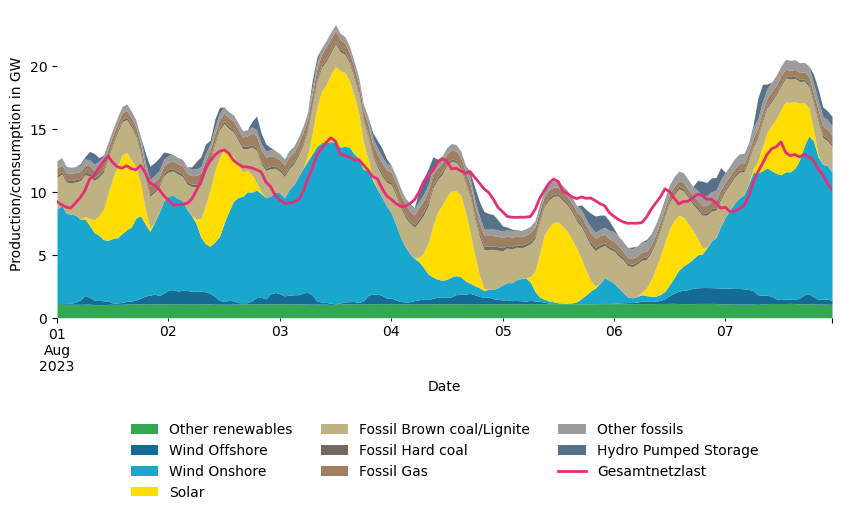

In [41]:
# Actual
if PAST:
    plot_generation(generation_df, color_dict, cons_df=consumption_df)

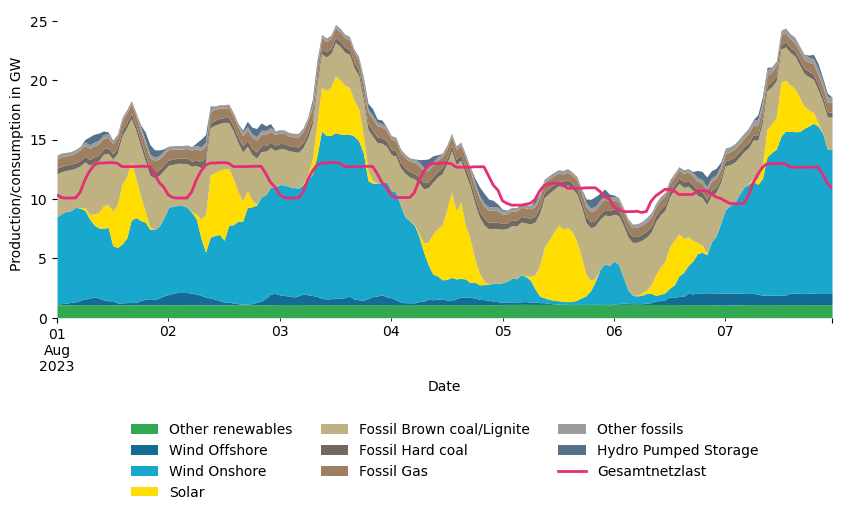

In [42]:
# Predicted
plot_generation(generation_forecast, color_dict, cons_df=consumption_forecast)

#### With emissions and price

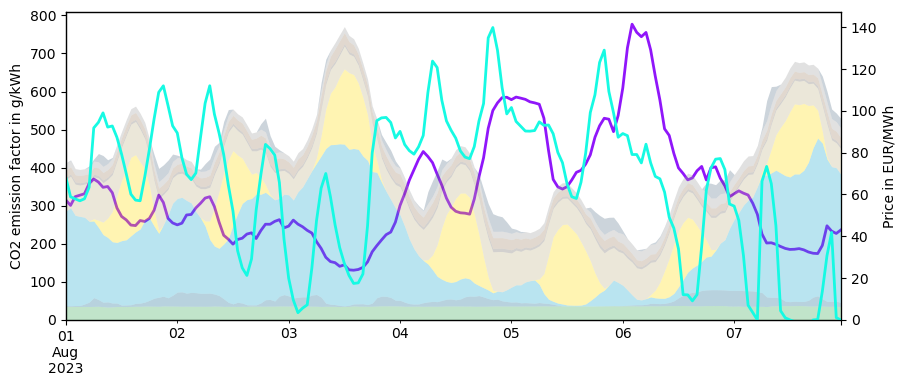

In [43]:
# Actual
if PAST:
    plot_generation(generation_df, color_dict, em_df=emission_df, pr_df=price_df)

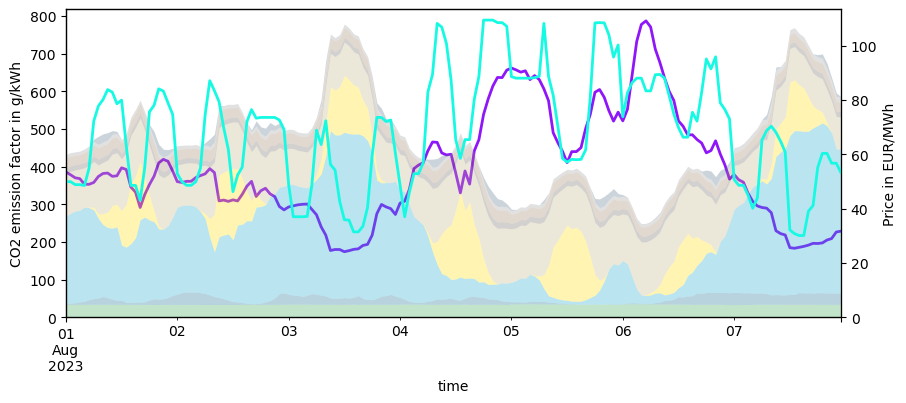

In [44]:
# Prediction
plot_generation(generation_forecast, color_dict, em_df=emissions_forecast, pr_df=price_forecast)